In [1]:
import sys, os; 
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from src.detr.detr import build_detr
from src.data.dataset import CPPE5Dataset, collate_fn
from src.losses.loss import DETRLoss
from src.data import transforms as T
from src.data.utils import visualize_output
from experiment.detr_config import DETRCPPEConfigSanityCheck
from experiment.detr_cppe5_experiment import DETRCPPE5Experiment
from runner.detr_runner import DETRRunner

from torch.utils.data import DataLoader
from PIL import Image

import torch
import numpy as np
import random
import json
import matplotlib.pyplot as plt

/home/leo/miniconda3/envs/cvrunner/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/leo/miniconda3/envs/cvrunner/lib/python3.10/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened bec

In [3]:
experiment = DETRCPPE5Experiment()
runner = DETRRunner(experiment)

[2025-10-17 23:24:02] [INFO] START INITIALIZING TRAIN RUNNER
[2025-10-17 23:24:02] [INFO] Using device: cuda
[2025-10-17 23:24:02] [INFO] Building model
[2025-10-17 23:24:02] [INFO] Done building model
[2025-10-17 23:24:02] [INFO] Building loss function
[2025-10-17 23:24:02] [INFO] Done building loss function
[2025-10-17 23:24:02] [INFO] Building dataloaders
[2025-10-17 23:24:02] [INFO] Building train CPPE-5 dataset...
[2025-10-17 23:24:11] [INFO] train dataset size: 1
[2025-10-17 23:24:11] [INFO] Building val CPPE-5 dataset...
[2025-10-17 23:24:18] [INFO] val dataset size: 1
[2025-10-17 23:24:18] [INFO] Done building dataloaders
[2025-10-17 23:24:18] [INFO] Building optimizer and learning rate scheduler
[2025-10-17 23:24:18] [INFO] Done building optimizer and learning rate scheduler
[2025-10-17 23:24:18] [INFO] DONE INITIALIZING TRAIN RUNNER
[2025-10-17 23:24:18] [INFO] Model config: DETRCPPEConfigSanityCheck(d_model=128, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedfo

In [4]:
!source ../.env

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
data_batch1 = next(iter(runner.train_dataloader))
data_batch2 = next(iter(runner.train_dataloader))

In [7]:
import copy

In [8]:
assert (data_batch1['images'] == data_batch2['images']).all(), "Images are not same"
assert (data_batch1['targets']['boxes'][0] == data_batch2['targets']['boxes'][0]).all(), "Boxes are not same"
assert (data_batch1['targets']['labels'][0] == data_batch2['targets']['labels'][0]).all(), "Labels are not same"
assert (data_batch1['masks'] == data_batch2['masks']).all(), "Masks are not same"

runner.model.eval()
with torch.no_grad():
    ## Data batch 1
    images1 = data_batch1["images"].to(device)
    masks1 = data_batch1["masks"].to(device)
    model1 = copy.deepcopy(runner.model)
    output1 = model1(images1, masks1)
    label1 = [item.to(device) for item in data_batch1["targets"]["labels"]]
    boxes1 = [item.to(device) for item in data_batch1["targets"]["boxes"]]

    loss1, prediction_output1 = runner.loss_function(label1, output1[0], boxes1, T.box_to_xy(output1[1]))

    ## Data batch 2
    images2 = data_batch2["images"].to(device)
    masks2 = data_batch2["masks"].to(device)
    model2 = copy.deepcopy(runner.model)
    output2 = model2(images2, masks2)
    label2 = [item.to(device) for item in data_batch2["targets"]["labels"]]
    boxes2 = [item.to(device) for item in data_batch2["targets"]["boxes"]]

    loss2, prediction_output2 = runner.loss_function(label2, output2[0], boxes2, T.box_to_xy(output2[1]))

    assert (images1 == images2).all(), "images mismatch"
    assert (masks1 == masks2).all(), "masks mismatch"
    for p1, p2 in zip(model1.parameters(), model2.parameters()):
        assert (p1 == p2).all(), "Models mismatch"
    print(output1[0], output2[0])
    print(output1[1], output2[1])
    assert (output1[0] == output2[0]).all(), "Output classes mismatch"

    assert (output1[1] == output2[1]).all(), "BBoxes mismatch"
    assert loss1 == loss2, "losses are not equal"
    for key in prediction_output1:
        assert (prediction_output1[key] == prediction_output2[key]).all(), f"Key {key} miss mask"

[2025-10-17 23:24:21] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:21] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:21] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:21] [INFO] Hungarian matching indices: [(array([3, 4, 2, 0, 1]), array([0, 3, 4, 6, 7]))]
[2025-10-17 23:24:21] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:21] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:21] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

In [9]:
def fit_one_epoch(runner: DETRRunner):
    # Visualize original prediction
    runner.model.eval()
    with torch.no_grad():
        data_batch = next(iter(runner.train_dataloader))
        images = data_batch["images"].to(device)
        masks = data_batch["masks"].to(device)
        output = runner.model(images, masks)
        label = [item.to(device) for item in data_batch["targets"]["labels"]]
        boxes = [item.to(device) for item in data_batch["targets"]["boxes"]]
        
        loss, prediction_output = runner.loss_function(label, output[0], boxes, T.box_to_xy(output[1]))

        ## Visualization
        image_ids = data_batch["targets"]["image_id"]

        ## The visualized boxes should be the boxes after Hungarian matching
        pred_boxes = prediction_output["pred_boxes"]
        pred_labels = prediction_output["pred_labels"]
        gt_boxes = prediction_output["gt_boxes"]
        gt_labels = prediction_output["gt_labels"]
        output_mask = prediction_output["masks"]


        ## Transform to list of valid boxes/lables
        gt_boxes_list = [
            gt_boxes[i][output_mask[i]].cpu() for i in range(gt_boxes.size(0))
        ]
        pred_boxes_list = [
            pred_boxes[i][output_mask[i]].cpu() for i in range(pred_boxes.size(0))
        ]
        gt_labels_list = [
            gt_labels[i][output_mask[i]].cpu() for i in range(gt_labels.size(0))
        ]
        pred_labels_list = [
            pred_labels[i][output_mask[i]].cpu() for i in range(pred_labels.size(0))
        ]

        before_images = visualize_output(
            imgs=images,
            masks=masks,
            image_ids=image_ids,
            out_labs=pred_labels_list,
            out_bboxes=pred_boxes_list,
            gt_labs=gt_labels_list,
            gt_bboxes=gt_boxes_list,
        )


    runner.model.train()
    # Train model
    data_batch = next(iter(runner.train_dataloader))
    runner.optimizer.zero_grad()
    images = data_batch["images"].to(device)
    masks = data_batch["masks"].to(device)
    output = runner.model(images, masks)
    label = [item.to(device) for item in data_batch["targets"]["labels"]]
    boxes = [item.to(device) for item in data_batch["targets"]["boxes"]]
    
    loss, prediction_output = runner.loss_function(label, output[0], boxes, T.box_to_xy(output[1]))
    loss.backward()
    torch.nn.utils.clip_grad_norm_(runner.model.parameters(), max_norm=0.1)
    runner.optimizer.step()
    runner.lr_scheduler.step()

    ## Visualization
    image_ids = data_batch["targets"]["image_id"]

    ## The visualized boxes should be the boxes after Hungarian matching
    pred_boxes = prediction_output["pred_boxes"]
    pred_labels = prediction_output["pred_labels"]
    gt_boxes = prediction_output["gt_boxes"]
    gt_labels = prediction_output["gt_labels"]

    ## Transform to list of valid boxes/lables
    gt_boxes_list = [
        gt_boxes[i][output_mask[i]].cpu() for i in range(gt_boxes.size(0))
    ]
    pred_boxes_list = [
        pred_boxes[i][output_mask[i]].cpu() for i in range(pred_boxes.size(0))
    ]
    gt_labels_list = [
        gt_labels[i][output_mask[i]].cpu() for i in range(gt_labels.size(0))
    ]
    pred_labels_list = [
        pred_labels[i][output_mask[i]].cpu() for i in range(pred_labels.size(0))
    ]
    output_mask = prediction_output["masks"]

    after_images = visualize_output(
        imgs=images,
        masks=masks,
        image_ids=image_ids,
        out_labs=pred_labels_list,
        out_bboxes=pred_boxes_list,
        gt_labs=gt_labels_list,
        gt_bboxes=gt_boxes_list,
    )

    fig, axes = plt.subplots(1, 2, figsize=(4, 6))
    axes[0].imshow(before_images[1])
    axes[0].set_title("Before")
    axes[0].axis("off")
    axes[1].imshow(after_images[1])
    axes[1].set_title("After")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

[2025-10-17 23:24:23] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:23] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:23] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:23] [INFO] Hungarian matching indices: [(array([3, 4, 2, 0, 1]), array([0, 3, 4, 6, 7]))]
[2025-10-17 23:24:24] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:24] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:24] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

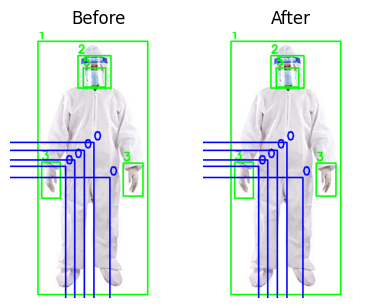

[2025-10-17 23:24:26] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:26] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:26] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:26] [INFO] Hungarian matching indices: [(array([4, 1, 2, 0, 3]), array([3, 4, 5, 8, 9]))]
[2025-10-17 23:24:27] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:27] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:27] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

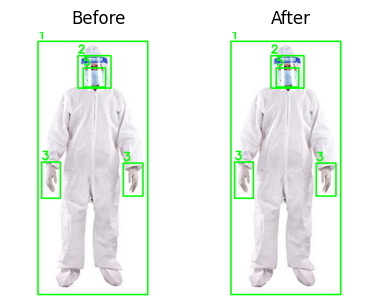

[2025-10-17 23:24:28] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:28] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:28] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:28] [INFO] Hungarian matching indices: [(array([1, 4, 0, 2, 3]), array([1, 2, 3, 5, 9]))]
[2025-10-17 23:24:29] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:29] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:29] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

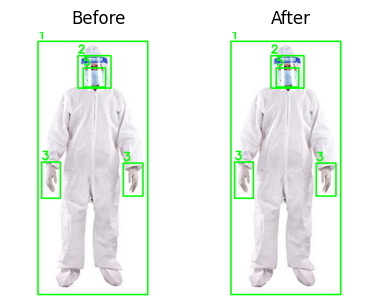

[2025-10-17 23:24:31] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:31] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:31] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0588, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:31] [INFO] Hungarian matching indices: [(array([1, 4, 0, 3, 2]), array([1, 2, 3, 5, 9]))]
[2025-10-17 23:24:32] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:32] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:32] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

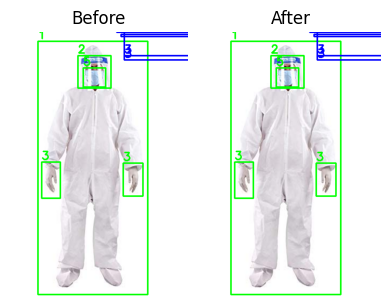

[2025-10-17 23:24:33] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:33] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:33] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:33] [INFO] Hungarian matching indices: [(array([3, 4, 0, 1, 2]), array([1, 4, 6, 7, 8]))]
[2025-10-17 23:24:34] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:34] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:34] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

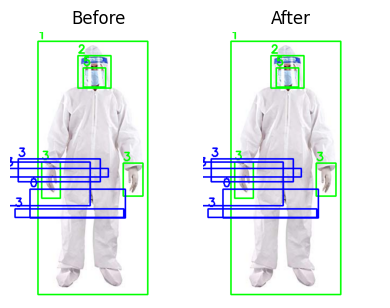

[2025-10-17 23:24:36] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:36] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:36] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:36] [INFO] Hungarian matching indices: [(array([1, 3, 4, 0, 2]), array([0, 1, 4, 6, 7]))]
[2025-10-17 23:24:37] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:37] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:37] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

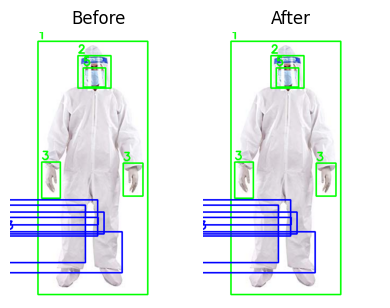

[2025-10-17 23:24:39] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:39] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:39] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0417, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:39] [INFO] Hungarian matching indices: [(array([4, 3, 2, 0, 1]), array([1, 2, 3, 6, 7]))]
[2025-10-17 23:24:40] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:40] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:40] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9943

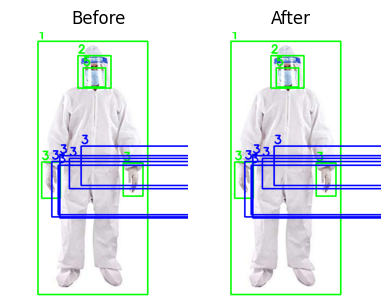

[2025-10-17 23:24:41] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:41] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:41] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:41] [INFO] Hungarian matching indices: [(array([4, 1, 3, 0, 2]), array([3, 4, 5, 8, 9]))]
[2025-10-17 23:24:42] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:42] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:42] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942

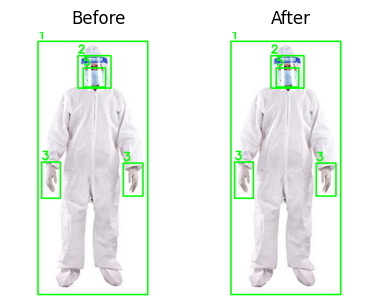

[2025-10-17 23:24:44] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:44] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:44] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:44] [INFO] Hungarian matching indices: [(array([1, 3, 0, 4, 2]), array([4, 5, 6, 8, 9]))]
[2025-10-17 23:24:45] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:45] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:45] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942

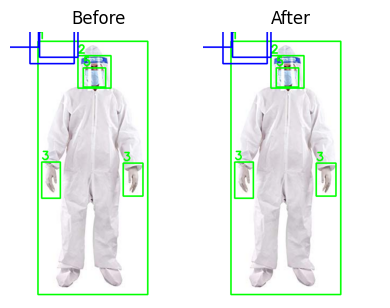

[2025-10-17 23:24:46] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:46] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:46] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:46] [INFO] Hungarian matching indices: [(array([1, 4, 3, 0, 2]), array([0, 1, 5, 7, 8]))]
[2025-10-17 23:24:47] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:47] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:47] [INFO] positional_enconding fraction tensor([[1.0213, 0.8678, 0.9942

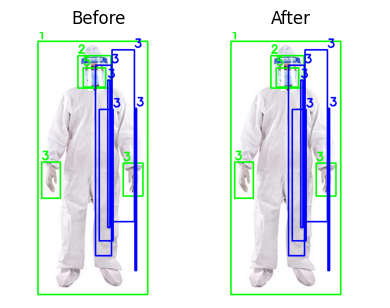

[2025-10-17 23:24:49] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:49] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:49] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:49] [INFO] Hungarian matching indices: [(array([3, 4, 2, 0, 1]), array([0, 1, 4, 6, 7]))]
[2025-10-17 23:24:50] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:50] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:50] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942

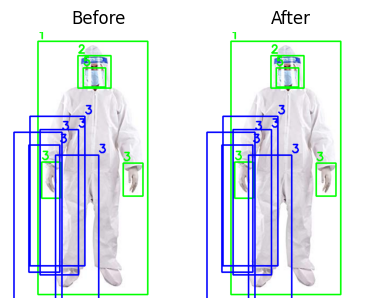

[2025-10-17 23:24:51] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:51] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:51] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:51] [INFO] Hungarian matching indices: [(array([4, 0, 1, 2, 3]), array([1, 6, 7, 8, 9]))]
[2025-10-17 23:24:53] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:53] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:53] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942

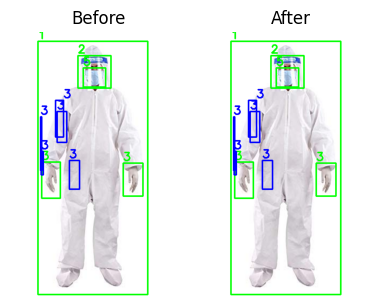

[2025-10-17 23:24:54] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:54] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:54] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:54] [INFO] Hungarian matching indices: [(array([1, 4, 0, 3, 2]), array([1, 2, 3, 5, 9]))]
[2025-10-17 23:24:55] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:55] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:55] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942

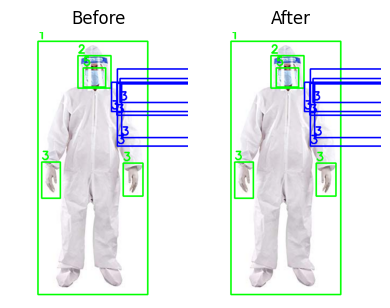

[2025-10-17 23:24:57] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:57] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:57] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:57] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([1, 2, 3, 5, 9]))]
[2025-10-17 23:24:58] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:58] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:58] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

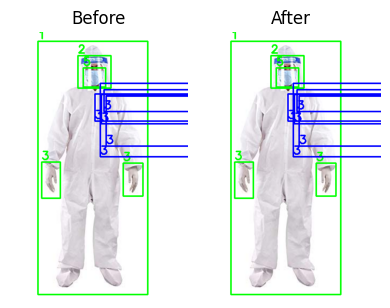

[2025-10-17 23:24:59] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:24:59] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:59] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:24:59] [INFO] Hungarian matching indices: [(array([4, 3, 0, 1, 2]), array([4, 5, 6, 7, 8]))]
[2025-10-17 23:25:01] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:01] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:01] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

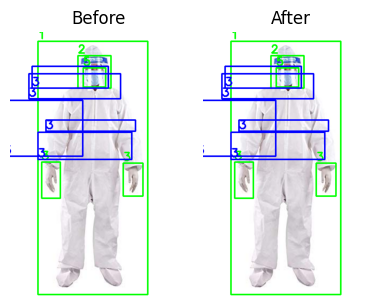

[2025-10-17 23:25:02] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:02] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:02] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:02] [INFO] Hungarian matching indices: [(array([2, 3, 0, 1, 4]), array([0, 4, 6, 7, 8]))]
[2025-10-17 23:25:03] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:03] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9346,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:03] [INFO] positional_enconding fraction tensor([[1.0212, 0.8678, 0.9942

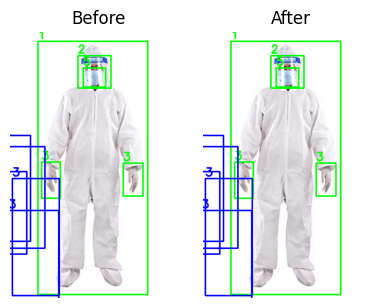

[2025-10-17 23:25:04] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:04] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:04] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:04] [INFO] Hungarian matching indices: [(array([3, 1, 4, 0, 2]), array([0, 4, 6, 7, 8]))]
[2025-10-17 23:25:06] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:06] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:06] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

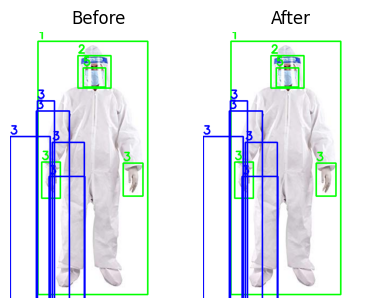

[2025-10-17 23:25:07] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:07] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:07] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0587, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:07] [INFO] Hungarian matching indices: [(array([1, 4, 0, 3, 2]), array([0, 1, 2, 5, 9]))]
[2025-10-17 23:25:08] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:08] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:08] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

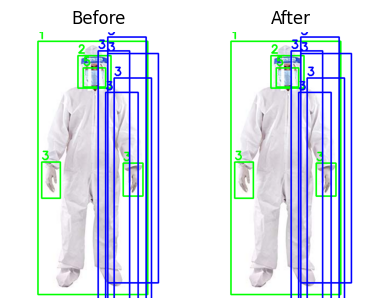

[2025-10-17 23:25:10] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:10] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:10] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:10] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([0, 2, 3, 5, 9]))]
[2025-10-17 23:25:11] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:11] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:11] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

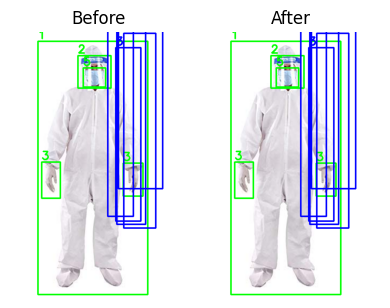

[2025-10-17 23:25:12] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:12] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:12] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:12] [INFO] Hungarian matching indices: [(array([0, 3, 1, 2, 4]), array([4, 5, 6, 8, 9]))]
[2025-10-17 23:25:13] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:13] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:13] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

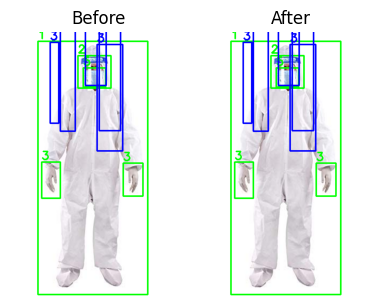

[2025-10-17 23:25:15] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:15] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9941, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:15] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:15] [INFO] Hungarian matching indices: [(array([4, 0, 1, 3, 2]), array([4, 6, 7, 8, 9]))]
[2025-10-17 23:25:16] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:16] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9941, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:16] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

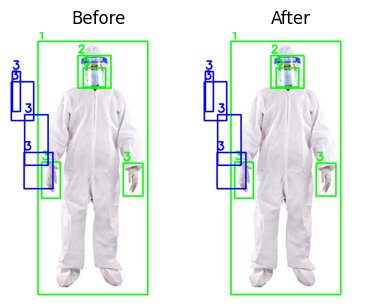

[2025-10-17 23:25:17] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:17] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:17] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0632, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:17] [INFO] Hungarian matching indices: [(array([3, 2, 0, 1, 4]), array([1, 4, 6, 7, 8]))]
[2025-10-17 23:25:19] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:19] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:19] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

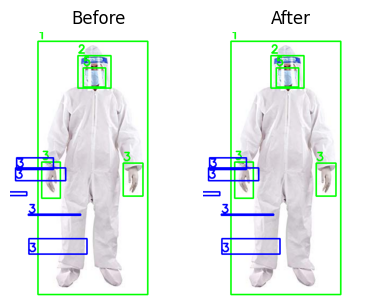

[2025-10-17 23:25:20] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:20] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:20] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:20] [INFO] Hungarian matching indices: [(array([2, 3, 4, 0, 1]), array([1, 2, 3, 6, 7]))]
[2025-10-17 23:25:21] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:21] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:21] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

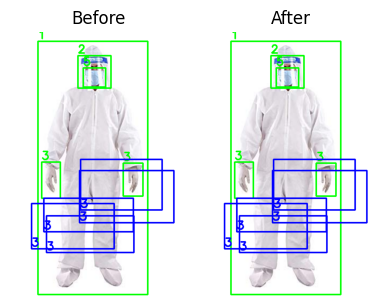

[2025-10-17 23:25:23] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:23] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:23] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:23] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([1, 2, 3, 5, 9]))]
[2025-10-17 23:25:24] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:24] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:24] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

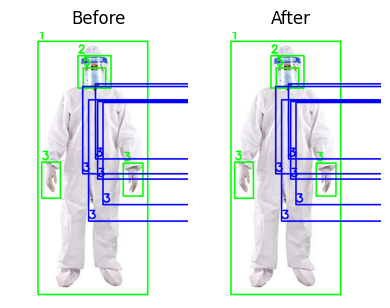

[2025-10-17 23:25:25] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:25] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:25] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:25] [INFO] Hungarian matching indices: [(array([1, 4, 0, 3, 2]), array([1, 2, 3, 5, 9]))]
[2025-10-17 23:25:27] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:27] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:27] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

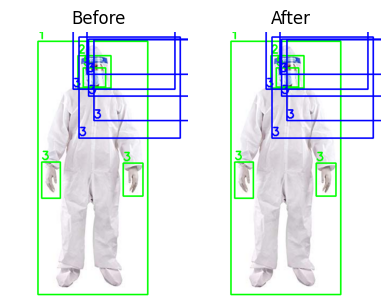

[2025-10-17 23:25:28] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:28] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:28] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:28] [INFO] Hungarian matching indices: [(array([4, 0, 3, 2, 1]), array([3, 4, 5, 8, 9]))]
[2025-10-17 23:25:29] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:29] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:29] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

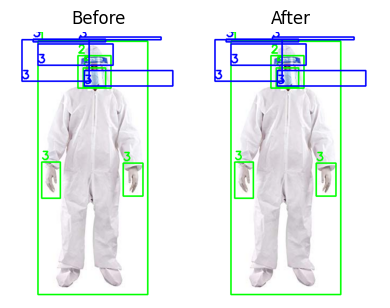

[2025-10-17 23:25:31] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:31] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:31] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0416, 1.0631, 1.0107, 0.9347,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:31] [INFO] Hungarian matching indices: [(array([4, 0, 1, 2, 3]), array([4, 6, 7, 8, 9]))]
[2025-10-17 23:25:32] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:32] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:32] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

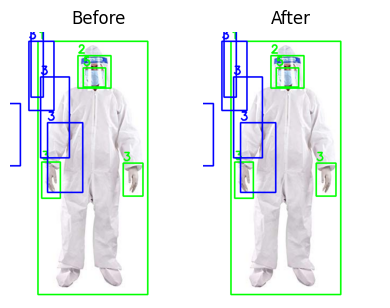

[2025-10-17 23:25:33] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:33] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:33] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:33] [INFO] Hungarian matching indices: [(array([3, 4, 0, 1, 2]), array([0, 4, 6, 7, 8]))]
[2025-10-17 23:25:34] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:34] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:34] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

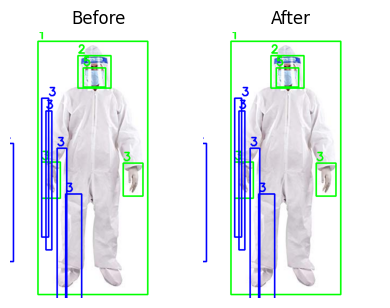

[2025-10-17 23:25:36] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:36] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:36] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:36] [INFO] Hungarian matching indices: [(array([3, 4, 2, 0, 1]), array([0, 1, 4, 6, 7]))]
[2025-10-17 23:25:37] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:37] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0586, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:37] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

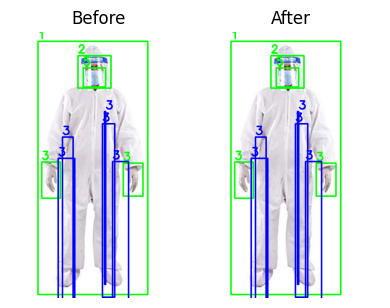

[2025-10-17 23:25:38] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:38] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:38] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:38] [INFO] Hungarian matching indices: [(array([0, 1, 4, 3, 2]), array([0, 1, 3, 5, 7]))]
[2025-10-17 23:25:39] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:39] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:39] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

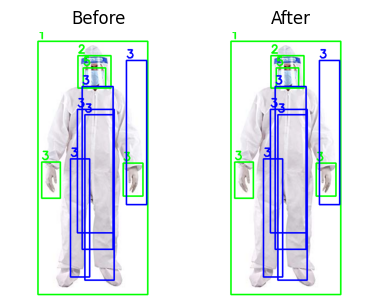

[2025-10-17 23:25:41] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:41] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:41] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:41] [INFO] Hungarian matching indices: [(array([1, 4, 3, 2, 0]), array([0, 3, 5, 8, 9]))]
[2025-10-17 23:25:42] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:42] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:42] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

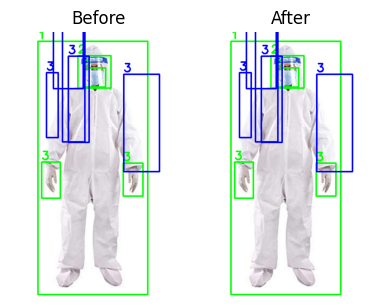

[2025-10-17 23:25:43] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:43] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:43] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9831, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:43] [INFO] Hungarian matching indices: [(array([3, 4, 1, 2, 0]), array([2, 3, 5, 8, 9]))]
[2025-10-17 23:25:44] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:44] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:44] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

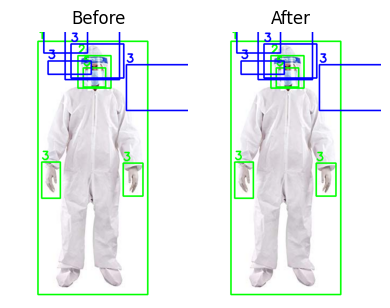

[2025-10-17 23:25:46] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:46] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:46] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9831, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:46] [INFO] Hungarian matching indices: [(array([0, 1, 4, 3, 2]), array([1, 2, 3, 5, 8]))]
[2025-10-17 23:25:47] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:47] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9347,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:47] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

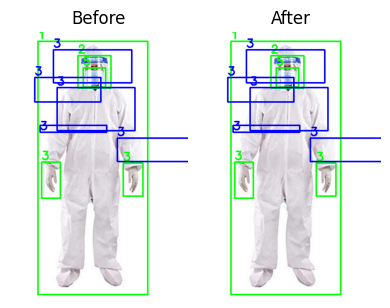

[2025-10-17 23:25:48] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:48] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:48] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9831, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:48] [INFO] Hungarian matching indices: [(array([0, 1, 3, 4, 2]), array([0, 1, 2, 3, 6]))]
[2025-10-17 23:25:49] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:49] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:49] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

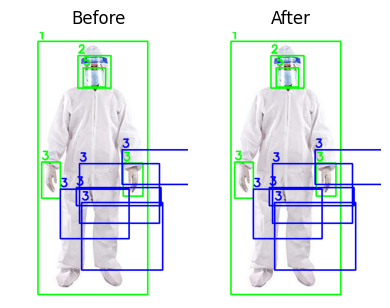

[2025-10-17 23:25:51] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:51] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:51] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9831, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:51] [INFO] Hungarian matching indices: [(array([0, 1, 3, 4, 2]), array([0, 1, 2, 6, 7]))]
[2025-10-17 23:25:52] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:52] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0631, 1.0106, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:52] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

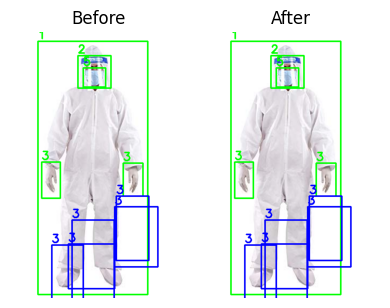

[2025-10-17 23:25:53] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:53] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:53] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:53] [INFO] Hungarian matching indices: [(array([4, 3, 2, 0, 1]), array([0, 1, 4, 6, 7]))]
[2025-10-17 23:25:54] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:54] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0416, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:54] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

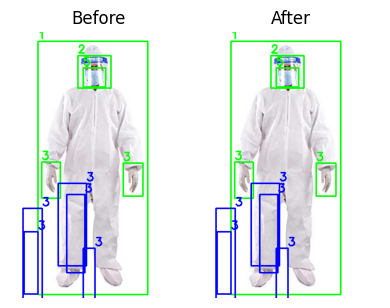

[2025-10-17 23:25:56] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:56] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:56] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:56] [INFO] Hungarian matching indices: [(array([3, 4, 2, 0, 1]), array([0, 3, 4, 6, 7]))]
[2025-10-17 23:25:57] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:57] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:57] [INFO] positional_enconding fraction tensor([[1.0212, 0.8677, 0.9942

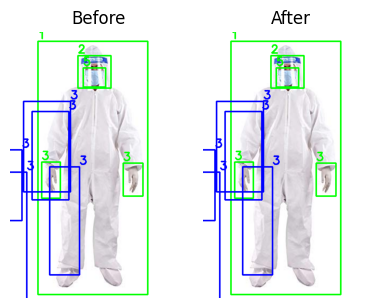

[2025-10-17 23:25:59] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:25:59] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:25:59] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:25:59] [INFO] Hungarian matching indices: [(array([4, 1, 3, 0, 2]), array([3, 4, 5, 6, 8]))]
[2025-10-17 23:26:00] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:00] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:00] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

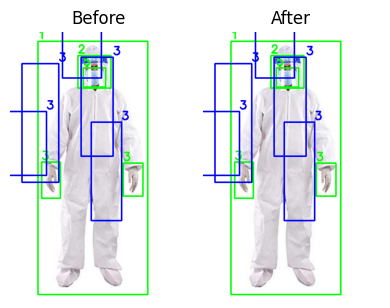

[2025-10-17 23:26:01] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:01] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:01] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8679]], device='cuda:0')
[2025-10-17 23:26:01] [INFO] Hungarian matching indices: [(array([1, 4, 3, 2, 0]), array([0, 3, 5, 8, 9]))]
[2025-10-17 23:26:02] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:02] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:02] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

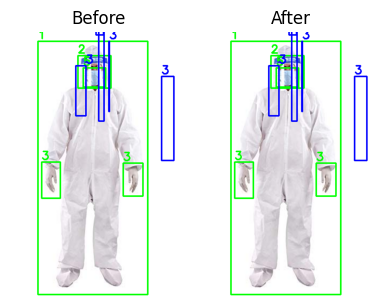

[2025-10-17 23:26:04] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:04] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:04] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9831, 1.0417, 1.0631, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:04] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([0, 2, 3, 5, 9]))]
[2025-10-17 23:26:05] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:05] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:05] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

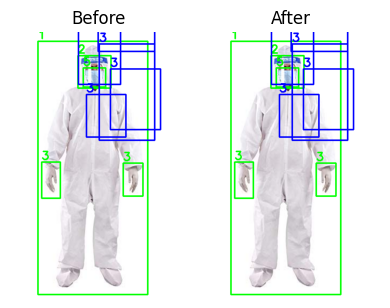

[2025-10-17 23:26:06] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:06] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:06] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9832, 1.0417, 1.0631, 1.0107, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:06] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([0, 1, 3, 5, 9]))]
[2025-10-17 23:26:07] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:07] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:07] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

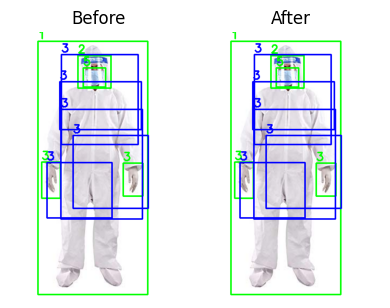

[2025-10-17 23:26:09] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:09] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:09] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:09] [INFO] Hungarian matching indices: [(array([2, 1, 0, 4, 3]), array([4, 6, 7, 8, 9]))]
[2025-10-17 23:26:10] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:10] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:10] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

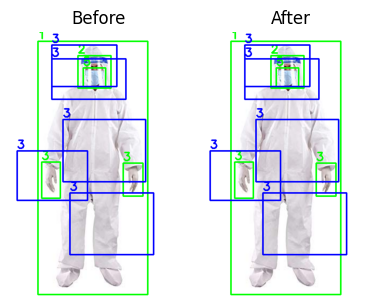

[2025-10-17 23:26:11] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:11] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:11] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942, 1.0586, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:11] [INFO] Hungarian matching indices: [(array([2, 3, 0, 1, 4]), array([0, 4, 6, 7, 8]))]
[2025-10-17 23:26:13] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:13] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:13] [INFO] positional_enconding fraction tensor([[1.0211, 0.8677, 0.9942

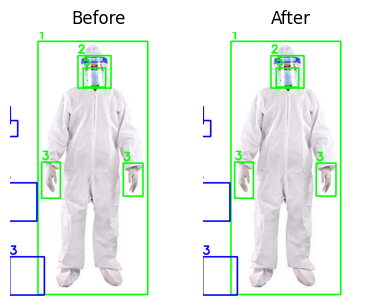

[2025-10-17 23:26:14] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:14] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:14] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942, 1.0586, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:14] [INFO] Hungarian matching indices: [(array([2, 3, 0, 1, 4]), array([1, 4, 6, 7, 8]))]
[2025-10-17 23:26:15] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:15] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:15] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942

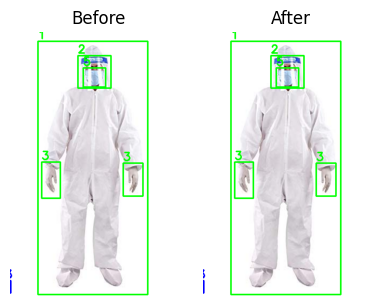

[2025-10-17 23:26:17] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:17] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:17] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942, 1.0586, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:17] [INFO] Hungarian matching indices: [(array([3, 2, 0, 1, 4]), array([1, 4, 6, 7, 8]))]
[2025-10-17 23:26:18] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:18] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:18] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942

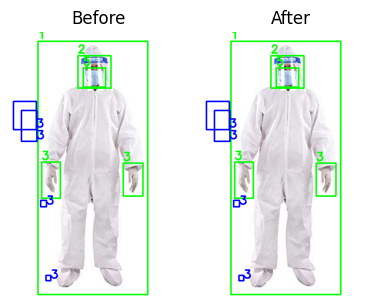

[2025-10-17 23:26:19] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:19] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:19] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942, 1.0586, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:19] [INFO] Hungarian matching indices: [(array([3, 2, 0, 1, 4]), array([3, 4, 6, 7, 8]))]
[2025-10-17 23:26:21] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:21] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:21] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942

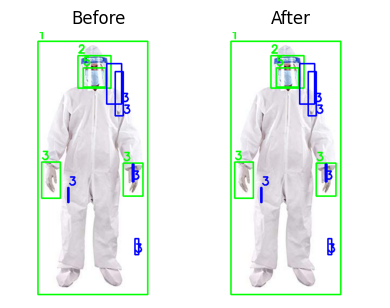

[2025-10-17 23:26:22] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:22] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:22] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942, 1.0586, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:22] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([0, 1, 3, 5, 9]))]
[2025-10-17 23:26:23] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:23] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:23] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942

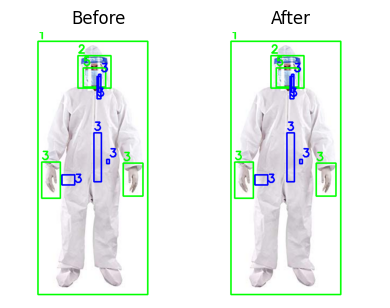

[2025-10-17 23:26:25] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:25] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:25] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942, 1.0585, 0.9832, 1.0418, 1.0631, 1.0108, 0.9349,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:25] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([0, 2, 3, 5, 9]))]
[2025-10-17 23:26:26] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:26] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:26] [INFO] positional_enconding fraction tensor([[1.0211, 0.8676, 0.9942

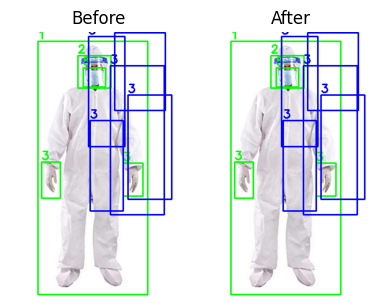

[2025-10-17 23:26:27] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:27] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:27] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9942, 1.0585, 0.9832, 1.0418, 1.0631, 1.0108, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:27] [INFO] Hungarian matching indices: [(array([1, 0, 4, 3, 2]), array([0, 2, 3, 5, 9]))]
[2025-10-17 23:26:29] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:29] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:29] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9942

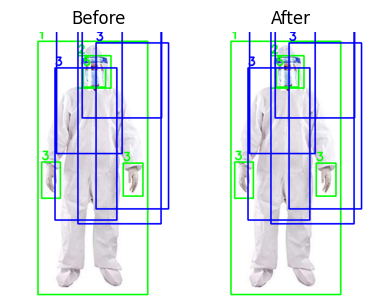

[2025-10-17 23:26:30] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:30] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:30] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9942, 1.0585, 0.9832, 1.0418, 1.0631, 1.0108, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:30] [INFO] Hungarian matching indices: [(array([0, 3, 1, 2, 4]), array([0, 5, 6, 8, 9]))]
[2025-10-17 23:26:31] [INFO] positional_enconding fraction tensor([[inf, inf, inf, inf, inf, inf, inf, inf, inf, inf]], device='cuda:0')
[2025-10-17 23:26:31] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9941, 1.0585, 0.9831, 1.0417, 1.0630, 1.0107, 0.9348,
         0.8678]], device='cuda:0')
[2025-10-17 23:26:31] [INFO] positional_enconding fraction tensor([[1.0210, 0.8676, 0.9942

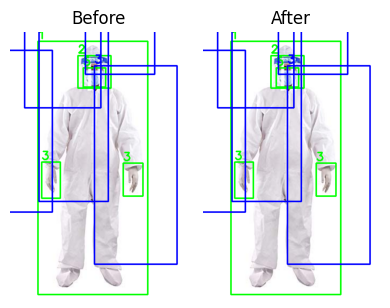

In [10]:
for i in range(50):
    fit_one_epoch(runner)

In [11]:
pos = runner.model.positional_encoding(torch.rand(3, 128, 34, 68))

In [12]:
pos

tensor([[[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
            0.0000e+00,  0.0000e+00],
          [ 8.4147e-01,  8.4147e-01,  8.4147e-01,  ...,  8.4147e-01,
            8.4147e-01,  8.4147e-01],
          [ 9.0930e-01,  9.0930e-01,  9.0930e-01,  ...,  9.0930e-01,
            9.0930e-01,  9.0930e-01],
          ...,
          [-4.0404e-01, -4.0404e-01, -4.0404e-01,  ..., -4.0404e-01,
           -4.0404e-01, -4.0404e-01],
          [ 5.5143e-01,  5.5143e-01,  5.5143e-01,  ...,  5.5143e-01,
            5.5143e-01,  5.5143e-01],
          [ 9.9991e-01,  9.9991e-01,  9.9991e-01,  ...,  9.9991e-01,
            9.9991e-01,  9.9991e-01]],

         [[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
            1.0000e+00,  1.0000e+00],
          [ 5.4030e-01,  5.4030e-01,  5.4030e-01,  ...,  5.4030e-01,
            5.4030e-01,  5.4030e-01],
          [-4.1615e-01, -4.1615e-01, -4.1615e-01,  ..., -4.1615e-01,
           -4.1615e-01, -4.1615e-01],
          ...,
     